 **CVNLP Assignment - Garbage Classification**


---



Line wrapping for viewing purposes only

In [2]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

## **Importing Essential Libraries**

In [1]:
import os
from google.colab import files
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix, classification_report

from IPython.display import display

## **Loading Dataset**

### Option 1: Loading and extracting data from zip file

In [ ]:
# This is for uploading our datasets zip file
uploaded = files.upload()

In [ ]:
# The below codes are directories for getting our zip files stored into colab
zip_path = '/content/garbage_classification.zip'  # Path to the uploaded zip file
extract_path = '/content/gdrive/MyDrive/garbage_classification'  # path to save the data later

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Set the data directory path for further processing
data_dir = extract_path

print(f"Data directory: {data_dir}")

### Option 2: Loading from Google Drive

Mounting notebook to Google Drive

In [4]:
import io
import requests
from google.colab import drive

drive.mount('/content/gdrive',force_remount=True)


Mounted at /content/gdrive


In [ ]:
#retrieve dataset from google drive
data_dir = "/content/gdrive/MyDrive/garbage_classification"

# This is to check whether we extracted our dataset successfully
if os.path.exists(data_dir):
    print("Directory exists!")
    print("Contents:", os.listdir(data_dir))
else:
    print("Directory does not exist. Check the path.")

Directory exists!
Contents: ['garbage_classification']


In [5]:
# Load data paths and identiy the number of classes in the dataset
data_dir = '/content/gdrive/MyDrive/garbage_classification/garbage_classification'
classes = os.listdir(data_dir)
print(f'classes found : [{classes}]')
data = []

for label in classes:
    folder_path = os.path.join(data_dir, label)
    for img_file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_file)
        data.append([img_path, label])

# Convert to DataFrame
image_df = pd.DataFrame(data, columns=['image_path', 'label'])

classes found : [['Battery', 'Metal', 'Paper', 'Plastic', 'Cardboard', 'Organic', 'Glass']]


In [ ]:
# This is simply a go-through for the content of our dataset
for root, dirs, files in os.walk(data_dir):
    print(f"Root: {root}")
    print(f"Directories: {dirs}")
    print(f"Files: {files}")
    print("----------")

Root: /content/gdrive/MyDrive/garbage_classification/garbage_classification
Directories: ['Battery', 'Metal', 'Paper', 'Plastic', 'Cardboard', 'Organic', 'Glass']
Files: []
----------
Root: /content/gdrive/MyDrive/garbage_classification/garbage_classification/Battery
Directories: []
Files: ['battery569.jpg', 'battery57.jpg', 'battery570.jpg', 'battery571.jpg', 'battery572.jpg', 'battery573.jpg', 'battery574.jpg', 'battery575.jpg', 'battery576.jpg', 'battery577.jpg', 'battery578.jpg', 'battery579.jpg', 'battery58.jpg', 'battery580.jpg', 'battery581.jpg', 'battery582.jpg', 'battery583.jpg', 'battery584.jpg', 'battery585.jpg', 'battery586.jpg', 'battery587.jpg', 'battery588.jpg', 'battery589.jpg', 'battery59.jpg', 'battery590.jpg', 'battery591.jpg', 'battery592.jpg', 'battery593.jpg', 'battery594.jpg', 'battery595.jpg', 'battery596.jpg', 'battery597.jpg', 'battery598.jpg', 'battery599.jpg', 'battery6.jpg', 'battery60.jpg', 'battery600.jpg', 'battery601.jpg', 'battery602.jpg', 'battery603.

### View sample dataset images

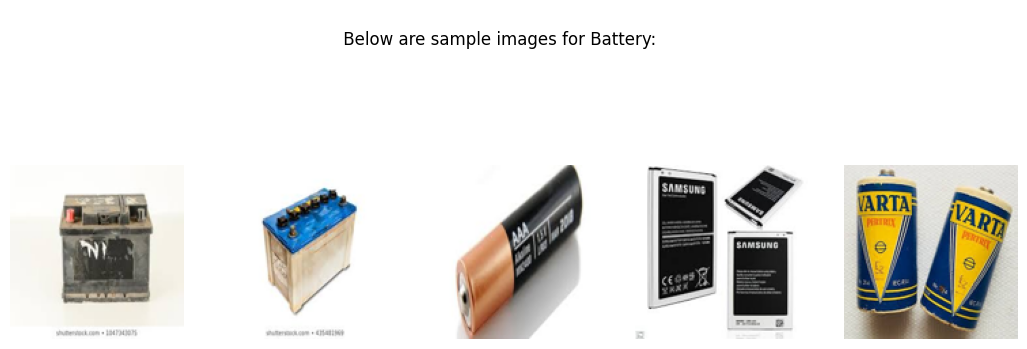

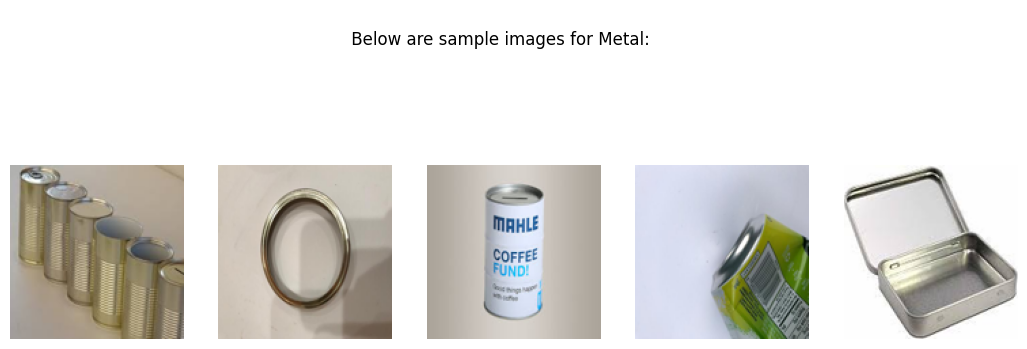

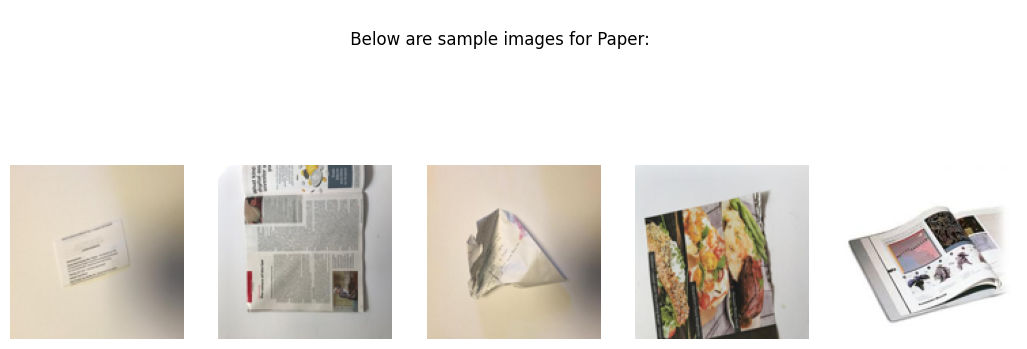

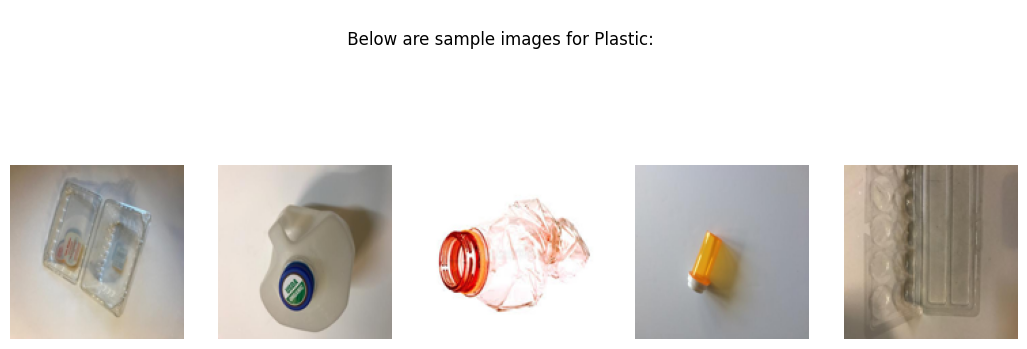

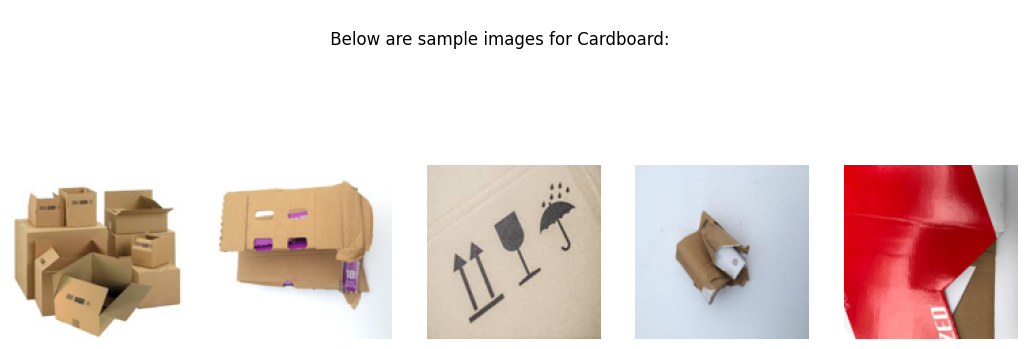

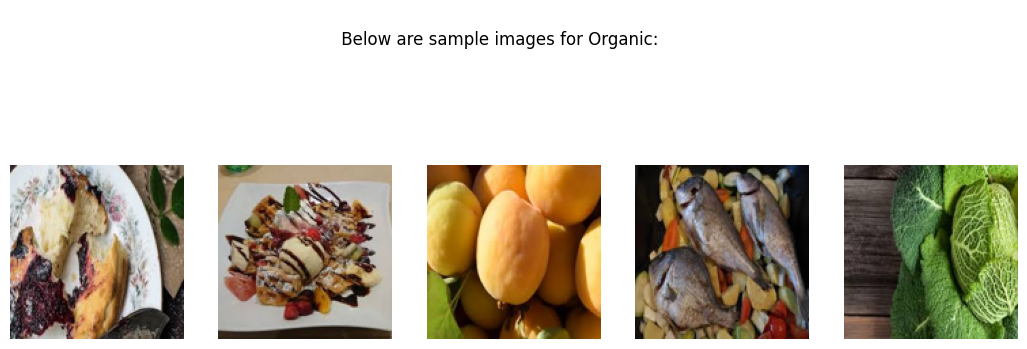

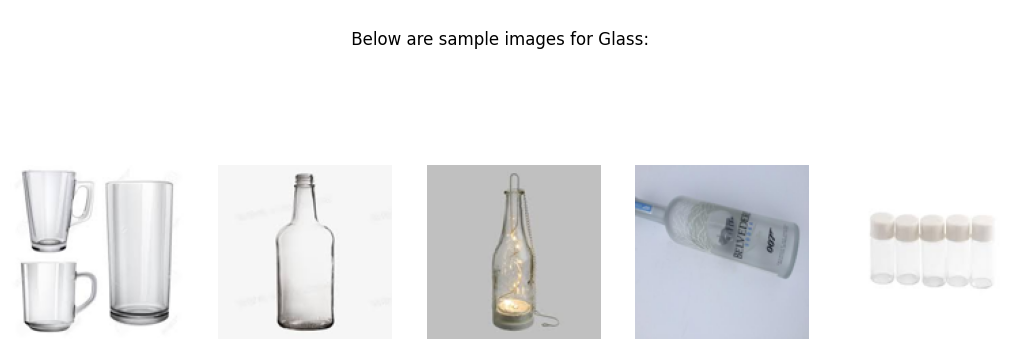

In [ ]:
# Load and resize sample images
def load_image(path, size=(128, 128)):
    img = Image.open(path)
    img = img.resize(size)
    return np.array(img)

# Show some sample images for each class
for label in classes:
    plt.figure(figsize=(13,5))
    plt.suptitle(f'\n Below are sample images for {label}:')
    sample_images = image_df[image_df['label'] == label]['image_path'].sample(5)
    for i, img_path in enumerate(sample_images):
        plt.subplot(1, 5, i+1)
        img = load_image(img_path)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

## **Data Preprocessing and Explorative Data Analysis (EDA)**

### Removing any missing data

In [ ]:
# Remove for any missing values in the dataframe

image_df.dropna(subset=['image_path'], inplace=True)
print(image_df.isnull().sum())

image_path    0
label         0
dtype: int64


### Barchart for class distribution

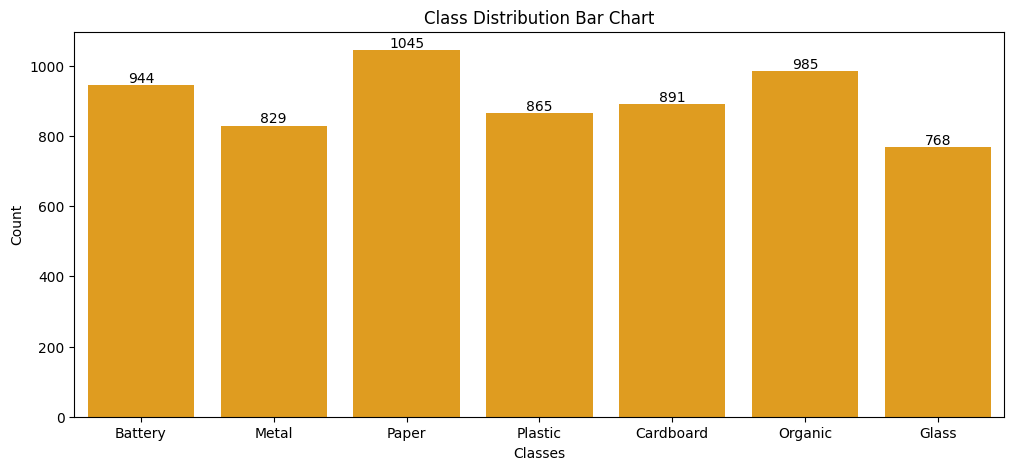

In [ ]:
# plot barchart of image class distribution
plt.figure(figsize=(12, 5))
sns.countplot(x='label', data=image_df, color= 'orange')
plt.title('Class Distribution Bar Chart')
plt.bar_label(plt.gca().containers[0])
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()


### Pie chart for class distribution

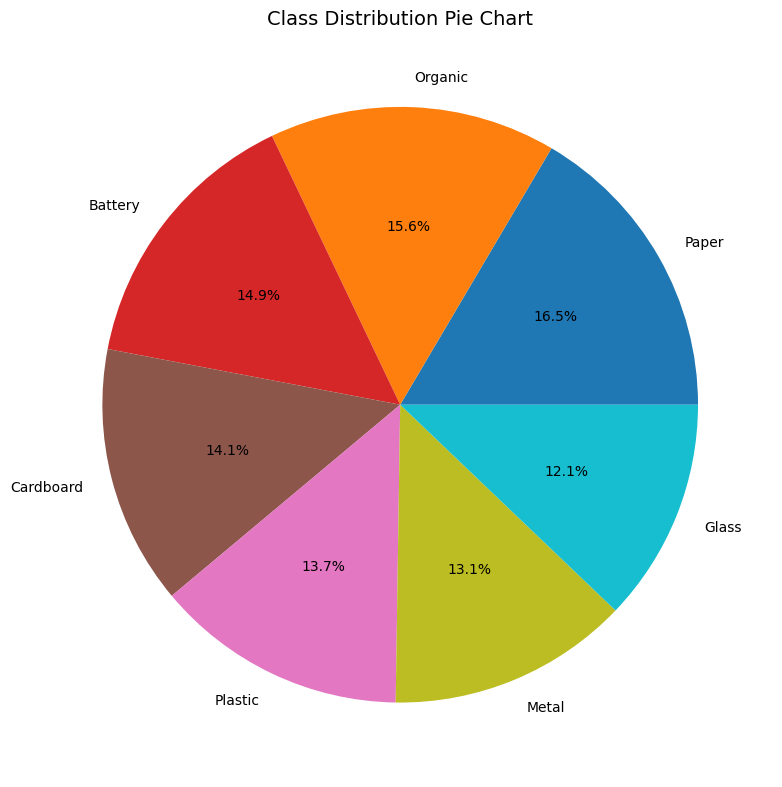

In [ ]:
# plot pie chart of image class distribution
class_counts = image_df['label'].value_counts()
plt.figure(figsize=(8, 8))
class_counts.plot.pie(cmap='tab10', autopct='%1.1f%%',legend=False)
plt.title('Class Distribution Pie Chart', fontsize=14)
plt.ylabel('')
plt.tight_layout()
plt.show()

# **Data Splitting**

Split the dataframe into Training, Validation, and Testing dataframes

In [6]:
# Shuffle the dataset
image_df = shuffle(image_df, random_state=42)

# Split into train, validation, and test sets on 0.7:0.2:0.1 ratio
train_data, temp_data = train_test_split(image_df, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.33, random_state=42)  # 10% test, 20% val

# Check splits
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

Training set size: 4456
Validation set size: 1280
Test set size: 631


# **Data Augmentation**

In [16]:
# This is Data Augmentation
# improve model generalization by creating variations of existing images)
# creates variations (e.g., rotated, flipped, or zoomed versions)of images
# during each batch but doesn't permanently increase the dataset size.

# Augment training data with rotation, zooming, flipping, etc.
train_datagen = ImageDataGenerator(
    rescale=1./255,                # Normalize pixel values
    rotation_range=25,             # Rotate images by up to 20 degrees
    zoom_range=0.25,                # Randomly zoom in
    horizontal_flip=True,          # Flip images horizontally
    vertical_flip=True,
    fill_mode='nearest'            # Fill empty pixels with nearest values
)

# No complex augmentation for validation and testing data, only rescaling
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create Generators for train, test, val dataframes
# and apply the relevant augmentations
print("Training set:")
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='image_path',
    y_col='label',
    target_size=(64,64),
    batch_size=32,
    class_mode='categorical'
)
print("\nValidation set:")
val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_data,
    x_col='image_path',
    y_col='label',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)
print("\nTesting set:")
test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col='image_path',
    y_col='label',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important for evaluation
)

Training set:
Found 4456 validated image filenames belonging to 7 classes.

Validation set:
Found 1280 validated image filenames belonging to 7 classes.

Testing set:
Found 631 validated image filenames belonging to 7 classes.


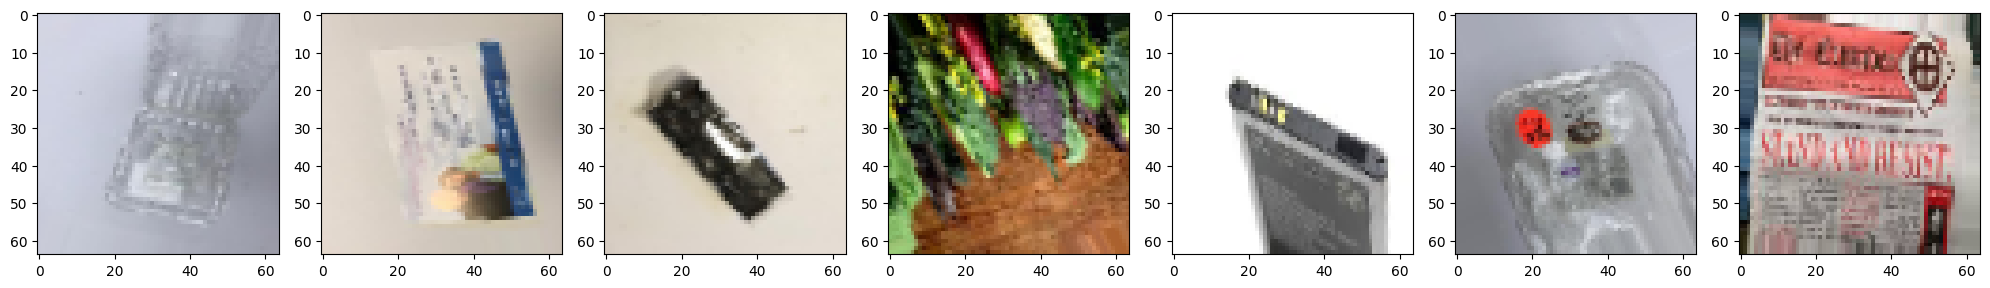

In [ ]:
#REFERENCE: Aenori/ECE_public (suggested by colab)
# -----------------------------------------------------------------------------

#show sample augmented images from the training dataset
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 7, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

#show random training images
sample_training_images, _ = next(train_generator)
random_indices = np.random.choice(sample_training_images.shape[0], size=10, replace=False)
random_images = sample_training_images[random_indices]
plotImages(random_images)

# **Model Architecture Designing and Implementation**

## Designing the model architecture

In [8]:
# CNN layer architecture configurations:
# 3 convolutional layers, 3 max pooling layers,
# 1 globalaveragepooling layer, 3 dropout layers, 2 dense layers

model = Sequential([

    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.35),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.35),

    GlobalAveragePooling2D(),

    Dense(128, activation='relu'),
    Dropout(0.45),
    Dense(len(classes), activation='softmax')

])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 110,663 (432.28 KB)

 Trainable params: 110,663 (432.28 KB)

 Non-trainable params: 0 (0.00 B)

## Visualise the model architecture

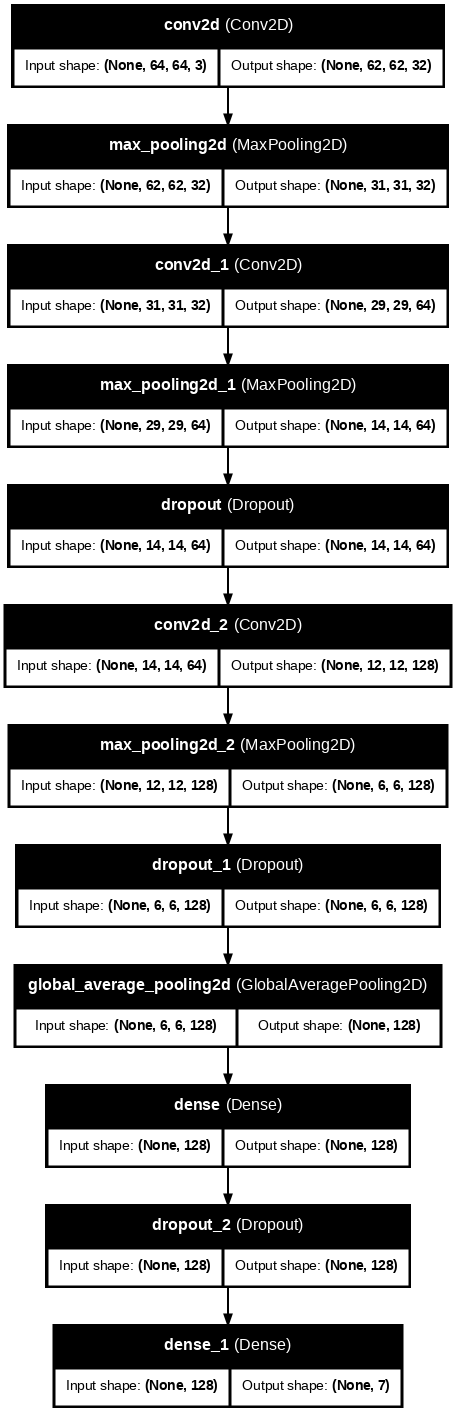

In [ ]:
# plot the model architecture layers
from tensorflow.keras.utils import plot_model

plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
    to_file='model_architecture.png',
    dpi=72  #smaller size
)

/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


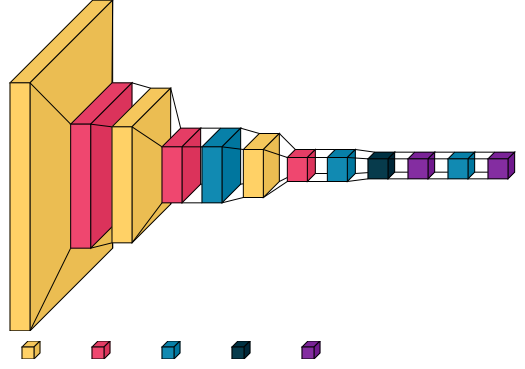

In [ ]:
#visualise the model layers using 3d representation
!pip install visualkeras
import visualkeras
visualkeras.layered_view(model, spacing = 20, legend = True)


Referring to the model visualisation above by colours:

* Yellow - convolutional layer
* Red - max pooling layer
* Blue - dropout layer
* Dark blue - GlobalAveragePooling layer
* Purple - dense layer


# **Model Training**

### Compile model

In [11]:
#compile model with adam optimiser
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

## Fit model for training

In [ ]:
#automatically halt epochs using EarlyStopping and by observing val_accuracy
#this is to reduce the tendency of the model being overfitted
early_stopping = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True)

#fit model for training
history = model.fit(
  train_generator,
  epochs=60,
  validation_data=val_generator,
  callbacks = early_stopping,
  verbose=1
)

Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


139/139 ━━━━━━━━━━━━━━━━━━━━ 96s 638ms/step - accuracy: 0.2619 - loss: 1.7895 - val_accuracy: 0.4536 - val_loss: 1.4101
Epoch 2/60
139/139 ━━━━━━━━━━━━━━━━━━━━ 111s 427ms/step - accuracy: 0.4500 - loss: 1.4052 - val_accuracy: 0.5000 - val_loss: 1.3443
Epoch 3/60
139/139 ━━━━━━━━━━━━━━━━━━━━ 83s 432ms/step - accuracy: 0.4916 - loss: 1.3508 - val_accuracy: 0.5039 - val_loss: 1.2943
Epoch 4/60
139/139 ━━━━━━━━━━━━━━━━━━━━ 62s 434ms/step - accuracy: 0.5318 - loss: 1.2559 - val_accuracy: 0.5472 - val_loss: 1.2105
Epoch 5/60
139/139 ━━━━━━━━━━━━━━━━━━━━ 81s 427ms/step - accuracy: 0.5385 - loss: 1.2458 - val_accuracy: 0.5425 - val_loss: 1.2719
Epoch 6/60
139/139 ━━━━━━━━━━━━━━━━━━━━ 83s 430ms/step - accuracy: 0.5619 - loss: 1.1737 - val_accuracy: 0.5668 - val_loss: 1.1761
Epoch 7/60
139/139 ━━━━━━━━━━━━━━━━━━━━ 63s 439ms/step - accuracy: 0.5853 - loss: 1.1525 - val_accuracy: 0.5904 - val_loss: 1.1204
Epoch 8/60
139/139 ━━━━━━━━━━━━━━━━━━━━ 84s 452ms/step - accuracy: 0.5808 - loss: 1.1287 - va

# **Model Evaluation and Metrics**

### Plot model accuracy over epochs

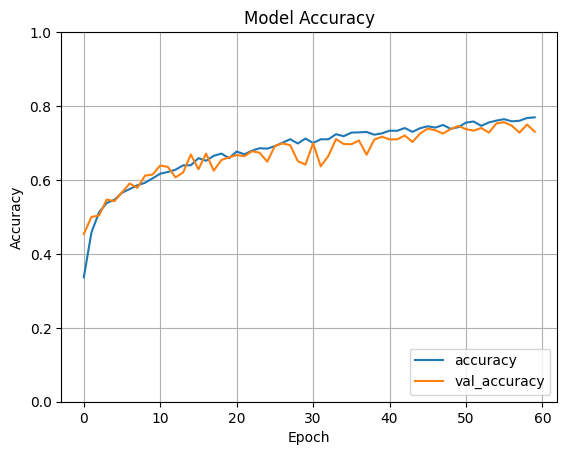

In [ ]:
# plot model accuracy over epochs
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


### Plot model loss over epochs

Text(0.5, 1.0, 'Model Loss')

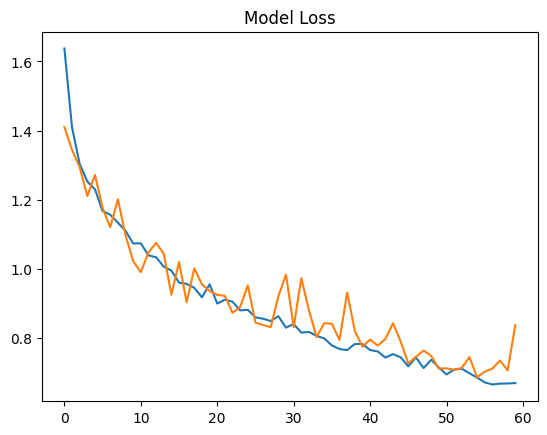

In [ ]:
# plot model loss across epochs
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.grid(True)

## Model Prediction and Evaluation

### Model training, validation, and testing accuracies

In [ ]:
# evaluate overall model training accuracy and loss
train_loss, train_accuracy = model.evaluate(train_generator)
train_accuracy = round(train_accuracy, 3)
print(f'Train Accuracy: {train_accuracy}')


139/139 ━━━━━━━━━━━━━━━━━━━━ 51s 366ms/step - accuracy: 0.8068 - loss: 0.5458
Train Accuracy: 0.804


In [ ]:
# evaluate overall model validation accuracy and loss
val_loss, val_accuracy = model.evaluate(val_generator)
val_accuracy = round(val_accuracy, 3)
print(f'Validation Accuracy: {val_accuracy}')

40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 279ms/step - accuracy: 0.7528 - loss: 0.7572
Validation Accuracy: 0.751


In [ ]:
# evaluate overall model testing accuracy and loss
test_true = test_generator.classes
test_pred = model.predict(test_generator)
test_pred_classes = np.argmax(test_pred, axis=1)
test_loss, test_accuracy = model.evaluate(test_generator)

test_accuracy = round(test_accuracy, 3)
print(f'Test Accuracy: {test_accuracy}')

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 337ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - accuracy: 0.7463 - loss: 0.7123
Test Accuracy: 0.761


### Classification Report

In [ ]:
# classification report
target_names = list(test_generator.class_indices.keys())
print(classification_report(test_true, test_pred_classes, target_names=target_names))

              precision    recall  f1-score   support

     Battery       0.79      0.82      0.81       104
   Cardboard       0.95      0.78      0.86        81
       Glass       0.82      0.58      0.68        81
       Metal       0.67      0.71      0.69        96
     Organic       0.91      0.83      0.87       103
       Paper       0.61      0.90      0.73        88
     Plastic       0.68      0.68      0.68        74

    accuracy                           0.76       627
   macro avg       0.78      0.75      0.76       627
weighted avg       0.78      0.76      0.76       627



### Confusion matrix

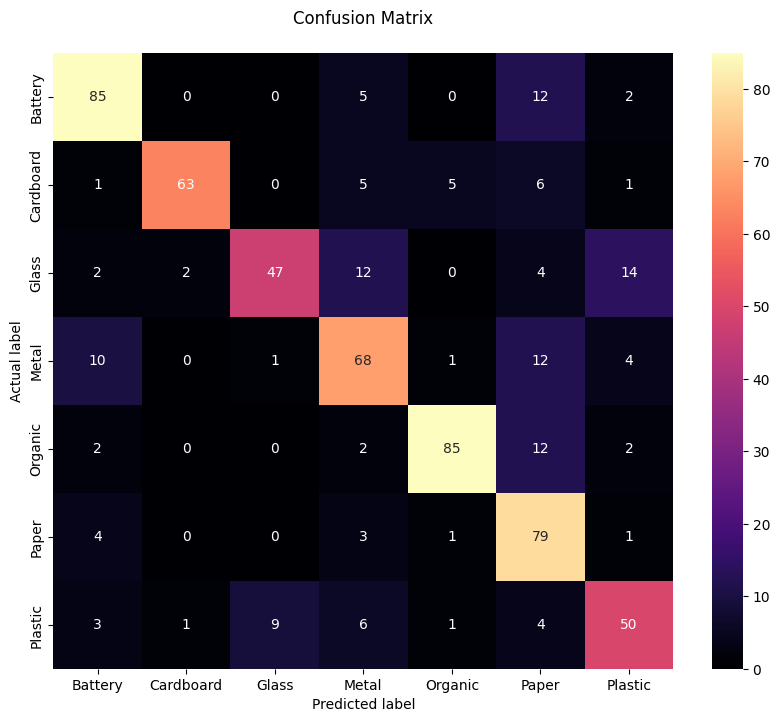

In [ ]:
# plot the confusion matrix
conf_m = confusion_matrix(test_true, test_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_m, annot=True, fmt='d', cmap='magma', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.title('Confusion Matrix\n')
plt.show()

Accuracy for Battery class: 81.73%
Accuracy for Cardboard class: 77.78%
Accuracy for Glass class: 58.02%
Accuracy for Metal class: 70.83%
Accuracy for Organic class: 82.52%
Accuracy for Paper class: 89.77%
Accuracy for Plastic class: 67.57%


Text(0.5, 1.0, 'Accuracy of Each Class')

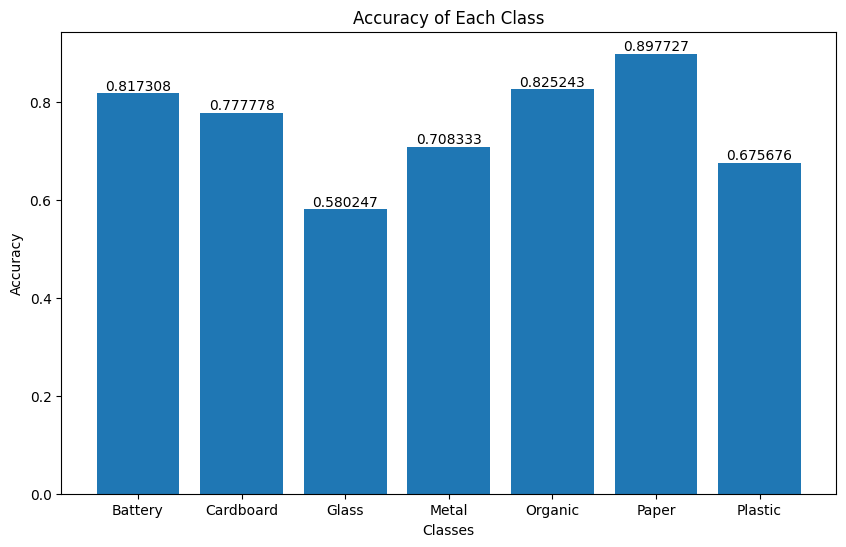

In [ ]:
#REFERENCE = https://scikit-learn.org/0.20/auto_examples/model_selection/plot_confusion_matrix.html
#REFERENCE = https://stackoverflow.com/questions/56084882/how-to-show-precision-in-a-confusion-matrix
#-------------------------------------------------------------------------------

#get the accuracy of each class (a.k.a. recall)
class_accuracy = (np.diag(conf_m) / np.sum(conf_m, axis=1))
for i, class_name in enumerate(target_names):
    print(f'Accuracy for {class_name} class: {class_accuracy[i]:.2%}')

#plot a bar chart for the accuracy of each class
plt.figure(figsize=(10, 6))
plt.bar(target_names, class_accuracy)
plt.bar_label(plt.gca().containers[0])
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.title('Accuracy of Each Class')

### Model Prediction

In [22]:
#define a function for model prediction

def predict_image(filepath, model):

  #some files might not have consistent namings according to numbers
  if not os.path.exists(filepath):
    print(f"File not found: {filepath}\n")
    return

  else:
    image_path = filepath
    image_true_class = image_path.split('/')[-2]
    img = Image.open(image_path).resize((64, 64))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Display the image
    img=img.resize((200,200))
    display(img)
    target_names = list(test_generator.class_indices.keys())
    # Make prediction
    predictions = model.predict(img_array)

    # Get the predicted class
    image_predicted_class = np.argmax(predictions[0])

    # Print the prediction
    print(f"Actual class: {image_true_class}")
    print(f"Predicted class: {target_names[image_predicted_class]}")

    if (target_names[image_predicted_class] == image_true_class):
      print("+++++++ Correct prediction! ++++++++\n")
    else:
      print("------- Wrong prediction -------- \n")

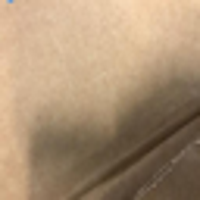

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Actual class: Cardboard
Predicted class: Cardboard
+++++++ Correct prediction! ++++++++



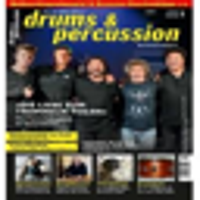

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Actual class: Paper
Predicted class: Paper
+++++++ Correct prediction! ++++++++



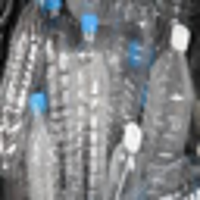

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Actual class: Plastic
Predicted class: Plastic
+++++++ Correct prediction! ++++++++



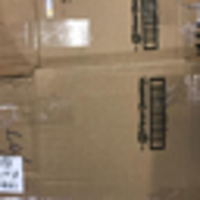

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Actual class: Cardboard
Predicted class: Cardboard
+++++++ Correct prediction! ++++++++



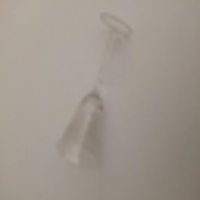

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Actual class: Glass
Predicted class: Glass
+++++++ Correct prediction! ++++++++



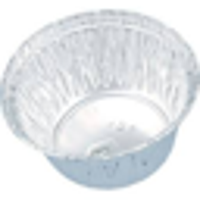

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Actual class: Metal
Predicted class: Glass
------- Wrong prediction -------- 



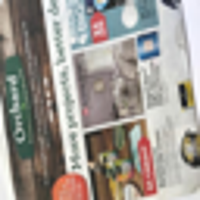

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Actual class: Paper
Predicted class: Paper
+++++++ Correct prediction! ++++++++



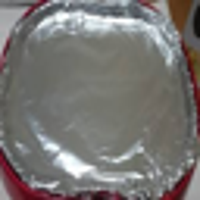

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Actual class: Metal
Predicted class: Plastic
------- Wrong prediction -------- 



In [43]:
#apply the prediction function to predict 8 random images from dataset
#and check whether the predictions aer correct

all_classes = ['Paper','Glass','Metal','Organic','Cardboard','Plastic','Battery']

for i in range(8):
  class1 = all_classes[np.random.randint(0,len(all_classes))]
  class_path = f'/content/gdrive/MyDrive/garbage_classification/garbage_classification/{class1}'
  random_int = np.random.randint(0, len(class_path))

  #some classes have been renamed for improved conventionality,
  #hence the exceptions
  if class1 == 'Glass':
    predict_image(f'{class_path}/white-{class1.lower()}{random_int}.jpg', model)
  elif class1 == 'Organic':
    predict_image(f'{class_path}/biological{random_int}.jpg', model)
  else:
    predict_image(f'{class_path}/{class1.lower()}{random_int}.jpg', model)

#if file is not found,
#it is likely because some file namings in some classes are not consistent and does not follow order